This notebook uses a new version of NaMaster (respect to the previous notebooks)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import check_covariance_code.common as co
import healpy as hp
import numpy as np
import pymaster as nmt
import os

In [3]:
prefix =  'run_sph_contaminants_ls100_ss100'
run_path = os.path.join('./simulations_outputs/', prefix, prefix)
data_folder = './data/'
sims_suffix = '_clsims_0001-20000.npz'
nside=512 # I think it can be read from somewhere

# Common

## Load theoretical data and sampled data

In [4]:
clTh = np.loadtxt(os.path.join(data_folder, "cls_lss.txt"), unpack=True)
lTh = clTh[0][:3*512]
clTh_TT = (clTh[1] + clTh[5])[:3*512]
clTh_EE = (clTh[2] + clTh[6])[:3*512]
clTh_BB = (clTh[3] + clTh[7])[:3*512]
clTh_TE = (clTh[4] + clTh[-1])[:3*512]
clTh_TB = clTh_EB = np.zeros(len(clTh_TE))
# l,cltt,clee,clbb,clte,nltt,nlee,nlbb,nlte=np.loadtxt("data/cls_lss.txt",unpack=True)
# cltt[0]=0; clee[0]=0; clbb[0]=0; clte[0]=0;
# nltt[0]=0; nlee[0]=0; nlbb[0]=0; nlte[0]=0;

In [5]:
clsims = np.load(run_path + sims_suffix)

In [6]:
mask_lss=hp.ud_grade(hp.read_map(os.path.join(data_folder, 'mask_lss_sph.fits'),verbose=False),nside_out=nside) 
fsky=np.mean(mask_lss)

In [7]:
def get_fields(w_cont=False) :
    """
    Generate a simulated field.
    It returns two NmtField objects for a spin-0 and a spin-2 field.

    :param fsk: a fm.FlatMapInfo object.
    :param mask: a sky mask.
    :param w_cont: deproject any contaminants? (not implemented yet)
    """
    st,sq,su=hp.synfast([clTh_TT,clTh_EE,clTh_BB, clTh_TE],nside,new=True,verbose=False,pol=True)
    if w_cont:
        if np.any(templates_all):
            tst, tsq, tsu = templates_all.sum(axis=0)
            st+=tst; sq+=tsq; su+=tsu;

        if o.no_deproject:
            ff0 = nmt.NmtField(mask_lss, [st])
            ff2 = nmt.NmtField(mask_lss, [sq, su])
        else:
            ff0 = nmt.NmtField(mask_lss, [st], templates_all[:, 0, None, :])
            ff2 = nmt.NmtField(mask_lss, [sq, su], templates_all[:, 1:, :])
    else :
        ff0=nmt.NmtField(mask_lss,[st])
        ff2=nmt.NmtField(mask_lss,[sq,su])
    return ff0,ff2

np.random.seed(1000)
f0,f2=get_fields()

### Simulations correlations

In [8]:
clTT = cl00 = np.reshape(clsims['cl00'], np.array(np.shape(clsims['cl00']))[[0,2]])
clTB = clsims['cl02'][:,1,:]
clTE = clsims['cl02'][:,0,:]
clEE = clsims['cl22'][:,0,:]
clEB = clsims['cl22'][:,1,:]
clBB = clsims['cl22'][:,3,:]
nlbins = len(clTT[0])
lbins = clsims['l']

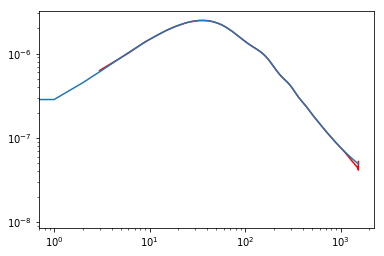

In [9]:
plt.plot(clsims['l'],np.mean(clTT,axis=0),'r-')
plt.plot(lTh,clTh_TT)
plt.loglog()
plt.show()
plt.close()

Healpix has bins of same area but its integrals are not completely exact. Sometimes the best we can do is up to (2 x nbins)

In [10]:
lmax = (clsims['l'] < 2*512).sum()

In [11]:
CovSims_path = run_path + '_cov'+sims_suffix
if os.path.isfile(CovSims_path):
    C = np.load(CovSims_path)['arr_0']
else:
    C = np.cov(np.concatenate([clTT.T, clTE.T, clTB.T, clEE.T, clEB.T, clBB.T]))
    np.savez_compressed(CovSims_path, C)
C = C.reshape((6, nlbins, 6, nlbins))

In [12]:
CovSims_TT = C[0, :, 0, :]
CovSims_TE = C[1, :, 1, :]
CovSims_TB = C[2, :, 2, :]
CovSims_EE = C[3, :, 3, :]
CovSims_EB = C[4, :, 4, :]
CovSims_BB = C[5, :, 5, :]

CovSims_TTTE = C[0, :, 1, :]
CovSims_TTTB = C[0, :, 2, :]
CovSims_TTEE = C[0, :, 3, :]
CovSims_TTEB = C[0, :, 4, :]
CovSims_TTBB = C[0, :, 4, :]

CovSims_TETB = C[1, :, 2, :]
CovSims_TEEE = C[1, :, 3, :]
CovSims_TEEB = C[1, :, 4, :]
CovSims_TEBB = C[1, :, 5, :]

CovSims_TBEE = C[2, :, 3, :]
CovSims_TBEB = C[2, :, 4, :]
CovSims_TBBB = C[2, :, 5, :]

CovSims_EEEB = C[3, :, 4, :]
CovSims_EEBB = C[3, :, 5, :]

CovSims_EBBB = C[4, :, 5, :]

### Analytic Covariances

In [13]:
w00 = nmt.NmtWorkspace()
w00.read_from(run_path + "_w00.dat")
w02 = nmt.NmtWorkspace()
w02.read_from(run_path + "_w02.dat")
w22 = nmt.NmtWorkspace()
w22.read_from(run_path + "_w22.dat")

We don't need to create a different covariance workspace for each spin combination because it only depends on the masks of the field

In [14]:
cw = nmt.NmtCovarianceWorkspace()
#cw02 = nmt.NmtCovarianceWorkspace()
#cw22 = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f0, f0)
#cw02.compute_coupling_coefficients(f0, f2)
#cw22.compute_coupling_coefficients(f2, f2)

In [15]:
cltt = clTh_TT
clte = clTh_TE
clee = clTh_EE
clbb = clTh_BB

if os.path.isfile(run_path+'_c0000.npz'):
    c0000 = np.load(run_path+'_c0000.npz')['arr_0']
else:
    c0000=nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltt],[cltt],[cltt],w00); print(c0000.shape)
    np.savez_compressed(run_path+'_c0000.npz', c0000)
    
if os.path.isfile(run_path+'_c0002.npz'):
    c0002 = np.load(run_path+'_c0002.npz')['arr_0']
else:
    c0002=nmt.gaussian_covariance(cw,0,0,0,2,[cltt],[clte,0*clte],[cltt],[clte,0*clte],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0002.shape)
    np.savez_compressed(run_path+'_c0002.npz', c0002)
    
if os.path.isfile(run_path+'_c0022.npz'):
    c0022 = np.load(run_path+'_c0022.npz')['arr_0']
else:
    c0022=nmt.gaussian_covariance(cw,0,0,2,2,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w00,w22).reshape((nlbins, 1, nlbins, 4)); print(c0022.shape)
    np.savez_compressed(run_path+'_c0022.npz', c0022)
    
if os.path.isfile(run_path+'_c0202.npz'):
    c0202 = np.load(run_path+'_c0202.npz')['arr_0']
else:
    c0202=nmt.gaussian_covariance(cw,0,2,0,2,[cltt],[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0202.shape)
    np.savez_compressed(run_path+'_c0202.npz', c0202)
    
if os.path.isfile(run_path+'_c0222.npz'):
    c0222 = np.load(run_path+'_c0222.npz')['arr_0']
else:
    c0222=nmt.gaussian_covariance(cw,0,2,2,2,[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w02,w22).reshape((nlbins, 2, nlbins, 4)); print(c0222.shape)
    np.savez_compressed(run_path+'_c0222.npz', c0222)
    
if os.path.isfile(run_path+'_c2222.npz'):
    c2222 = np.load(run_path+'_c2222.npz')['arr_0']
else:
    c2222=nmt.gaussian_covariance(cw,2,2,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w22,w22).reshape((nlbins, 4, nlbins, 4)); print(c2222.shape)
    np.savez_compressed(run_path+'_c2222.npz', c2222)
    
    
# c0020=nmt.gaussian_covariance(cw,0,0,2,0,[clte,0*clte],[cltt],[clte,0*clte],[cltt],w00,w02); print(c0020.shape)
#c0200=nmt.gaussisloan_covariance(cw,0,2,0,0,[cltt],[cltt],[clte,0*clte],[clte,0*clte],w02,w00); print(c0200.shape)
#c0220=nmt.gaussian_covariance(cw,0,2,2,0,[clte,0*clte],[cltt],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w02,w02); print(c0220.shape)
#c2000=nmt.gaussian_covariance(cw,2,0,0,0,[clte,0*clte],[clte,0*clte],[cltt],[cltt],w02,w00); print(c2000.shape)
#c2002=nmt.gaussian_covariance(cw,2,0,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[cltt],[clte,0*clte],w02,w02); print(c2002.shape)
#c2020=nmt.gaussian_covariance(cw,2,0,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],[cltt],w02,w02); print(c2020.shape)
#c2022=nmt.gaussian_covariance(cw,2,0,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],w02,w22); print(c2022.shape)
#c2200=nmt.gaussian_covariance(cw,2,2,0,0,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w22,w00); print(c2200.shape)
#c2202=nmt.gaussian_covariance(cw,2,2,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w22,w02); print(c2202.shape)
#c2220=nmt.gaussian_covariance(cw,2,2,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w22,w02); print(c2220.shape)

CovTh_TT = c0000
CovTh_TTTE, CovTh_TTTB = c0002[:, 0, :, [0, 1]]
CovTh_TTEE, CovTh_TTEB, CovTh_TTBE, CovTh_TTBB = c0022[:, 0, :, [0, 1, 2, 3]]
CovTh_TETE, CovTh_TETB = c0202[:, 0, :, [0, 1] ]
CovTh_TBTE, CovTh_TBTB = c0202[:, 1, :, [0, 1] ]
CovTh_TEEE, CovTh_TEEB, CovTh_TEBE, CovTh_TEBB =  c0222[:, 0, :, [0, 1, 2, 3] ]
CovTh_TBEE, CovTh_TBEB, CovTh_TBBE, CovTh_TBBB = c0222[:, 1, :, [0, 1, 2, 3] ]
CovTh_EEEE, CovTh_EEEB, CovTh_EEBE, CovTh_EEBB = c2222[:, 0, :, [0, 1, 2, 3] ]
CovTh_EBEE, CovTh_EBEB, CovTh_EBBE, CovTh_EBBB = c2222[:, 1, :, [0, 1, 2, 3] ]
CovTh_BEEE, CovTh_BEEB, CovTh_BEBE, CovTh_BEBB = c2222[:, 2, :, [0, 1, 2, 3] ]
CovTh_BBEE, CovTh_BBEB, CovTh_BBBE, CovTh_BBBB = c2222[:, 3, :, [0, 1, 2, 3] ]

CovTh_TE = CovTh_TETE
CovTh_TB = CovTh_TBTB
CovTh_EE = CovTh_EEEE
CovTh_EB = CovTh_EBEB
CovTh_BB = CovTh_BBBB

#### Spin 2 ~ Spin 0

In [16]:
cltt = clTh_TT
clte = clTh_TE
cltb = clbe = 0 * cltt
clee = clTh_EE
cleb = clbe = 0 * clee
clbb = clTh_BB

CovTh0_TT = CovTh_TT
CovTh0_TE = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[clte],[clte],[clee],w00)
CovTh0_TB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[cltb],[clbb],w00)
CovTh0_EE = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[clee],[clee],[clee],w00)
CovTh0_EB = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[cleb],[cleb],[clbb],w00)
CovTh0_BB = nmt.gaussian_covariance(cw,0,0,0,0,[clbb],[clbb],[clbb],[clbb],w00)

CovTh0_TTTE = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[clte],[cltt],[clte],w00)
CovTh0_TTTB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[cltt],[cltb],w00)
CovTh0_TTEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clte],[clte],w00)
CovTh0_TTEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clte],[cltb],w00)
CovTh0_TTBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[cltb],[cltb],w00)

CovTh0_TETB = nmt.gaussian_covariance(cw,0,0,0,0,[cltt],[cltb],[clte],[cleb],w00)
CovTh0_TEEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clee],[clee],w00)
CovTh0_TEEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clee],[cleb],w00)
CovTh0_TEBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[cleb],[cleb],w00)

CovTh0_TBEE = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[clte],[clbe],[clbe],w00)
CovTh0_TBEB = nmt.gaussian_covariance(cw,0,0,0,0,[clte],[cltb],[clbe],[clbb],w00)
CovTh0_TBBB = nmt.gaussian_covariance(cw,0,0,0,0,[cltb],[cltb],[clbb],[clbb],w00)

CovTh0_EEEB = nmt.gaussian_covariance(cw,0,0,0,0,[clee],[cleb],[clee],[cleb],w00)
CovTh0_EEBB = nmt.gaussian_covariance(cw,0,0,0,0,[cleb],[cleb],[cleb],[cleb],w00)

CovTh0_EBBB = nmt.gaussian_covariance(cw,0,0,0,0,[cleb],[clbb],[cleb],[clbb],w00)

#### Naive approx

In [17]:
d_ell=int(1./fsky)
b=nmt.NmtBin(nside,nlb=d_ell)
l0=b.get_effective_ells()-d_ell/2
lf=b.get_effective_ells()+d_ell/2

CovThN_TT = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TT, clTh_TT, clTh_TT)
CovThN_TE = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TE, clTh_TE, clTh_EE)
CovThN_TB = co.naive_covariance(lTh, l0, lf, fsky, clTh_TT, clTh_TB, clTh_TB, clTh_BB)
CovThN_EE = co.naive_covariance(lTh, l0, lf, fsky, clTh_EE, clTh_EE, clTh_EE, clTh_EE)
CovThN_EB = co.naive_covariance(lTh, l0, lf, fsky, clTh_EE, clTh_EB, clTh_EB, clTh_BB)
CovThN_BB = co.naive_covariance(lTh, l0, lf, fsky, clTh_BB, clTh_BB, clTh_BB, clTh_BB)

CovThN_TTTE = co.naive_covariance(lTh, l0, lf, fsky, cltt, clte, cltt, clte)
CovThN_TTTB = co.naive_covariance(lTh, l0, lf, fsky, cltt, cltb, cltt, cltb)
CovThN_TTEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clte, clte)
CovThN_TTEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clte, cltb)
CovThN_TTBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, cltb, cltb)

CovThN_TETB = co.naive_covariance(lTh, l0, lf, fsky, cltt, cltb, clte, cleb)
CovThN_TEEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clee, clee)
CovThN_TEEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clee, cleb)
CovThN_TEBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, cleb, cleb)

CovThN_TBEE = co.naive_covariance(lTh, l0, lf, fsky, clte, clte, clbe, clbe)
CovThN_TBEB = co.naive_covariance(lTh, l0, lf, fsky, clte, cltb, clbe, clbb)
CovThN_TBBB = co.naive_covariance(lTh, l0, lf, fsky, cltb, cltb, clbb, clbb)

CovThN_EEEB = co.naive_covariance(lTh, l0, lf, fsky, clee, cleb, clee, cleb)
CovThN_EEBB = co.naive_covariance(lTh, l0, lf, fsky, cleb, cleb, cleb, cleb)

CovThN_EBBB = co.naive_covariance(lTh, l0, lf, fsky, cleb, clbb, cleb, clbb)

# Efstathiou approximation

## TTTT

Checks for TTTT
Diagonal covariance matrix


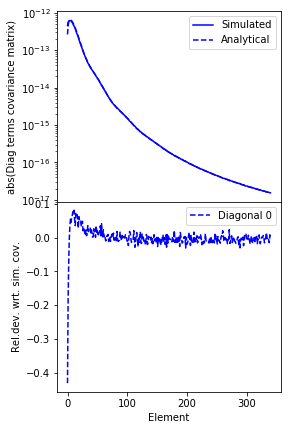

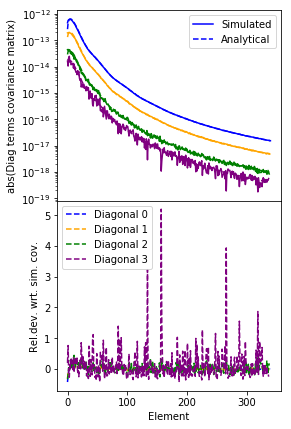

Chi2 distribution check


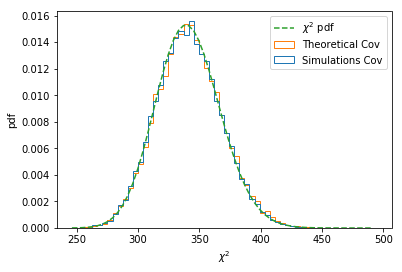

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.01100000000000001, pvalue=0.17668113134476654)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0071964520517123765, pvalue=0.2514750451452012)
KS between th. and chi2 distributions:  KstestResult(statistic=0.013833558769296928, pvalue=0.0009476296955860927)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008228460890405187, pvalue=0.13326019883263776)

Difference between analytic and sims. correlation matrix


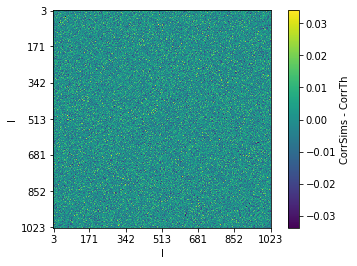

Eigenvalues vs l


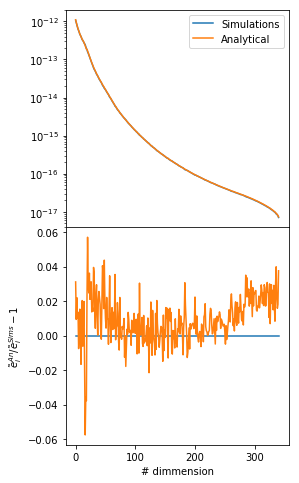

Row of cov. matrix.


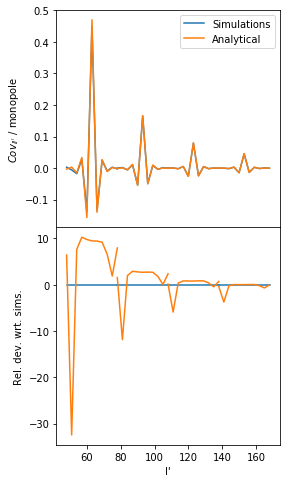

In [18]:
chi2_TTTT, corr_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh_TT[:lmax, :lmax], modes="TTTT")

## TETE

Checks for TETE
Diagonal covariance matrix


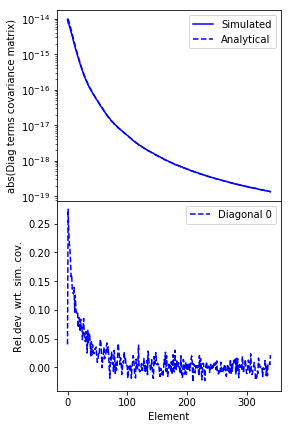

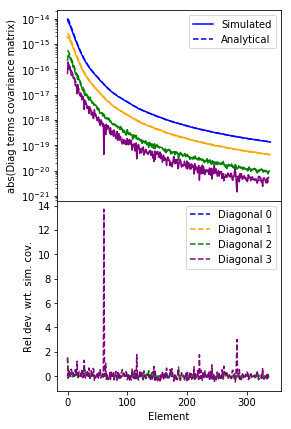

Chi2 distribution check


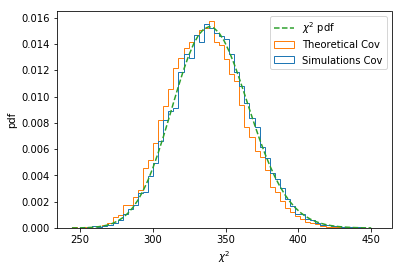

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.06764999999999999, pvalue=2.8413517836664863e-40)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.00371748567619834, pvalue=0.9450677806629686)
KS between th. and chi2 distributions:  KstestResult(statistic=0.06565919727303615, pvalue=2.564649170242669e-75)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003415508131070985, pvalue=0.9737766316642829)

Difference between analytic and sims. correlation matrix


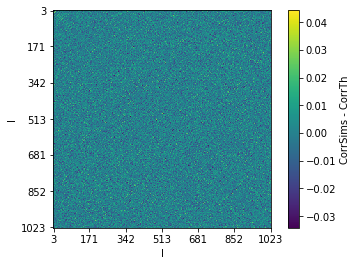

Eigenvalues vs l


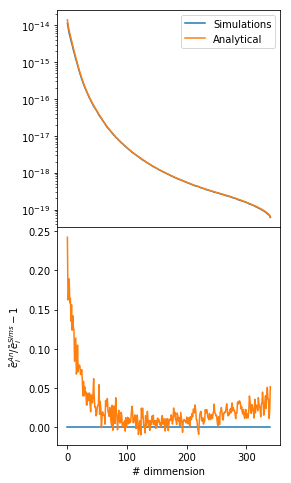

Row of cov. matrix.


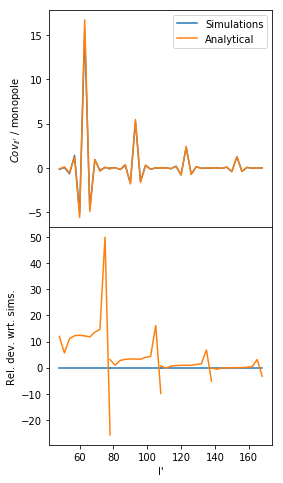

In [19]:
chi2_TETE, corr_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh_TETE[:lmax, :lmax], modes="TETE")

## EEEE

Checks for EEEE
Diagonal covariance matrix


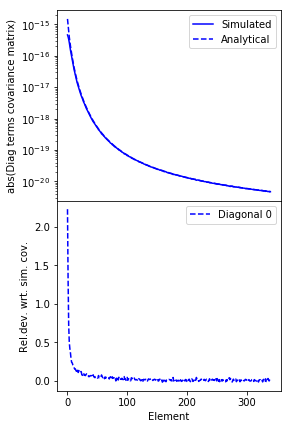

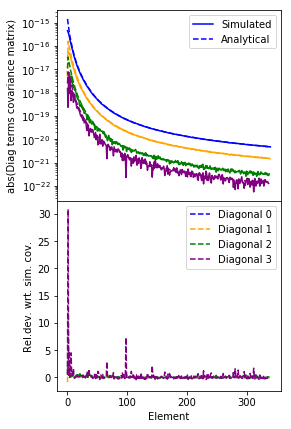

Chi2 distribution check


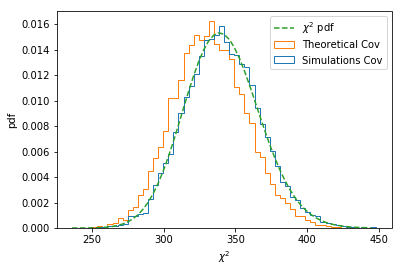

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.13279999999999997, pvalue=5.582597363649708e-154)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.003853499483614242, pvalue=0.9277813605188122)
KS between th. and chi2 distributions:  KstestResult(statistic=0.13255611034702158, pvalue=1.1464898044015764e-305)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.010797452332573787, pvalue=0.0188686637771891)

Difference between analytic and sims. correlation matrix


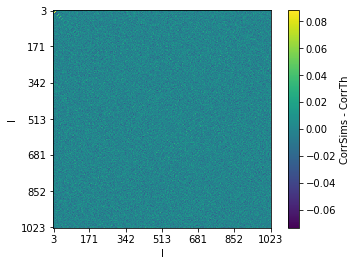

Eigenvalues vs l


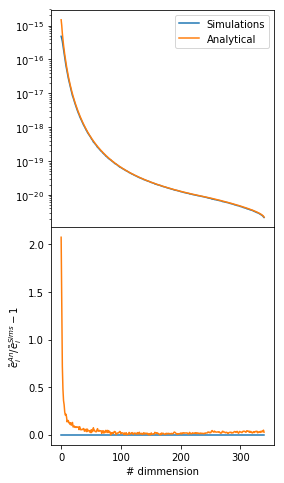

Row of cov. matrix.


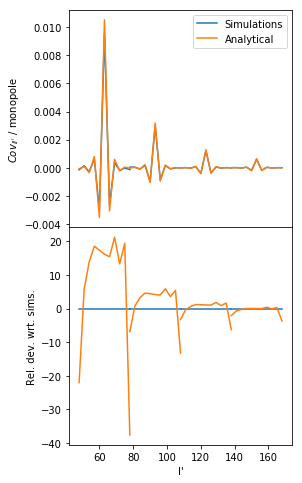

In [20]:
chi2_EEEE, corr_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh_EEEE[:lmax, :lmax], modes="EEEE")

## BBBB

Checks for BBBB
Diagonal covariance matrix


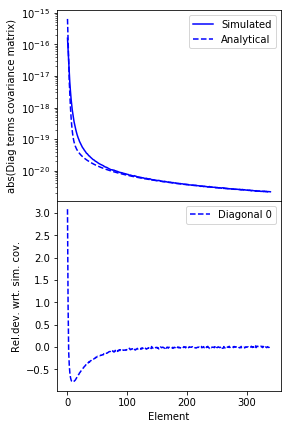

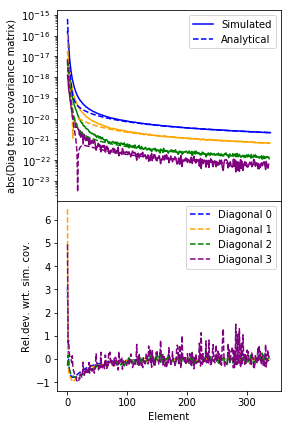

Chi2 distribution check


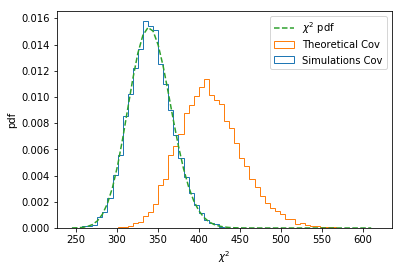

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.7511, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.008255590597542772, pvalue=0.1308996205190951)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7532572026940578, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006072536054161359, pvalue=0.45206990172287326)

Difference between analytic and sims. correlation matrix


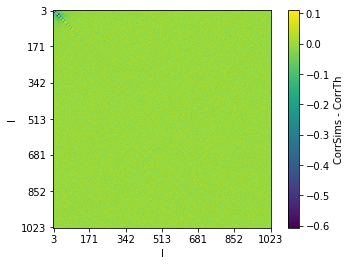

Eigenvalues vs l


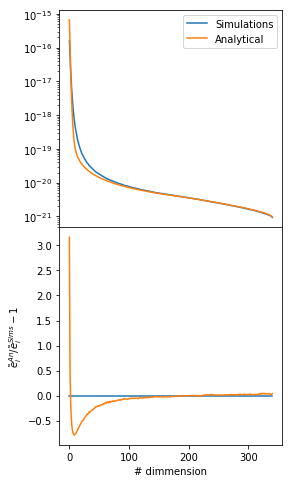

Row of cov. matrix.


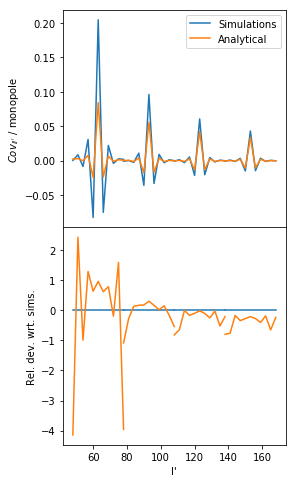

In [21]:
chi2_BBBB, corr_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh_BBBB[:lmax, :lmax], modes="BBBB")

## TBTB

Checks for TBTB
Diagonal covariance matrix


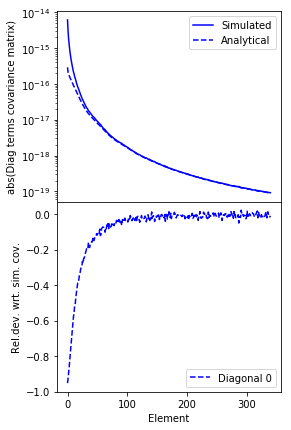

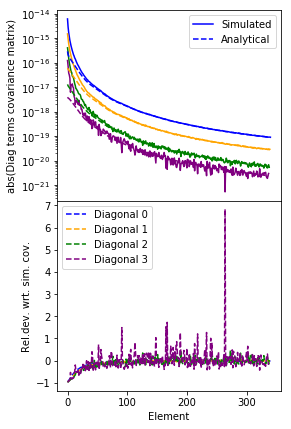

Chi2 distribution check


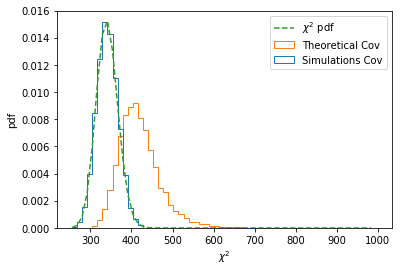

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.72685, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004426630850170449, pvalue=0.8280716263397345)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7270367617385121, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006588483621867591, pvalue=0.35040739181649033)

Difference between analytic and sims. correlation matrix


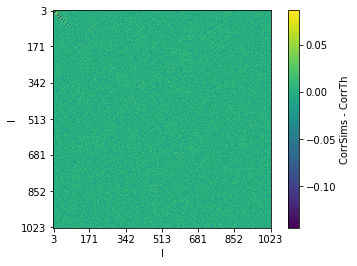

Eigenvalues vs l


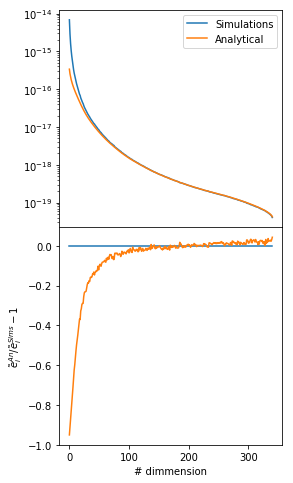

Row of cov. matrix.


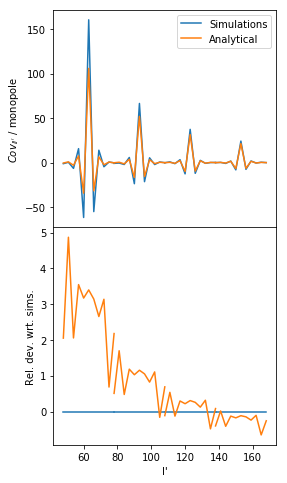

In [22]:
chi2_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh_TBTB[:lmax, :lmax], modes="TBTB")

## EBEB

Checks for EBEB
Diagonal covariance matrix


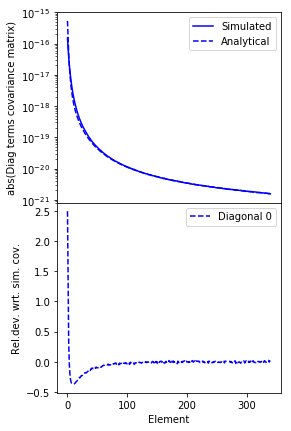

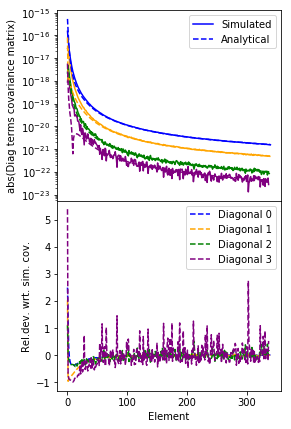

Chi2 distribution check


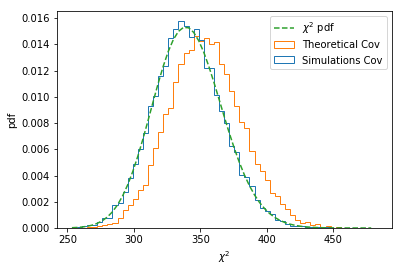

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.19429999999999997, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005585428445099849, pvalue=0.5606612915280346)
KS between th. and chi2 distributions:  KstestResult(statistic=0.1907227938239623, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003855246266848522, pvalue=0.9275419013707239)

Difference between analytic and sims. correlation matrix


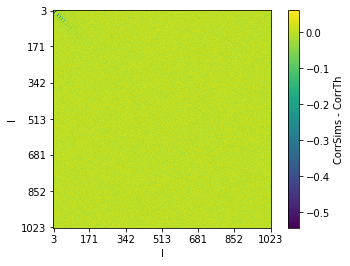

Eigenvalues vs l


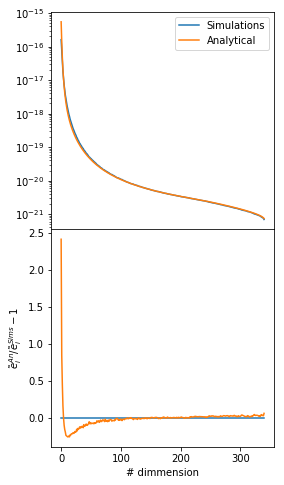

Row of cov. matrix.


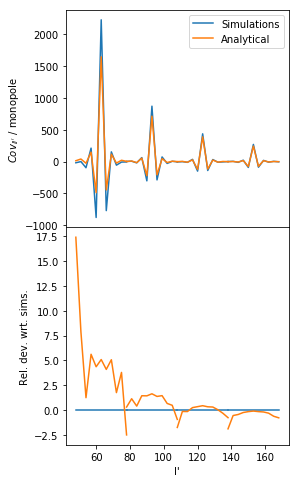

In [23]:
chi2_EBEB, corr_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh_EBEB[:lmax, :lmax], modes="EBEB")

## TTTE

Checks for TTTE
Diagonal covariance matrix


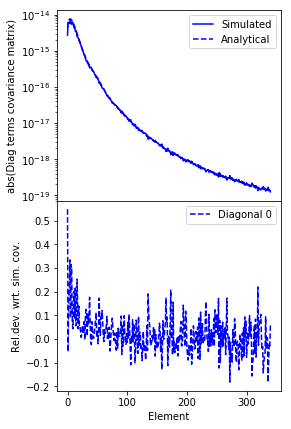

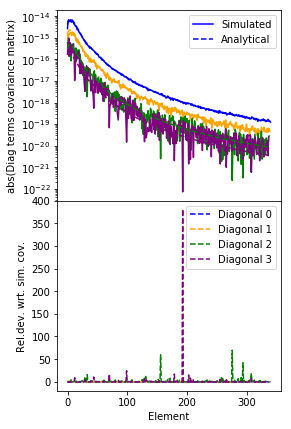

Chi2 distribution check


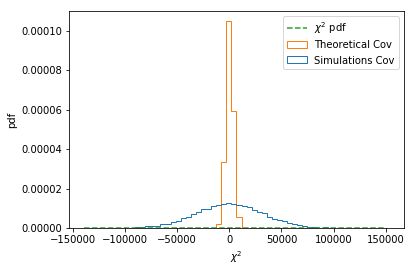

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.3963, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.5039186429124556, pvalue=0.0)
KS between th. and chi2 distributions:  KstestResult(statistic=0.49400116943046296, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00725857162221466, pvalue=0.24265260871560915)

Difference between analytic and sims. correlation matrix


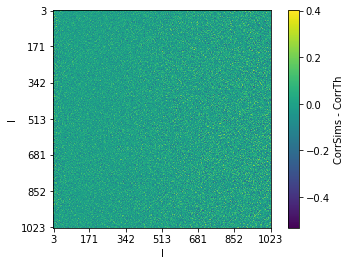

Eigenvalues vs l


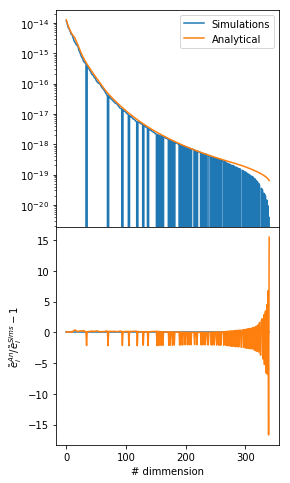

Row of cov. matrix.


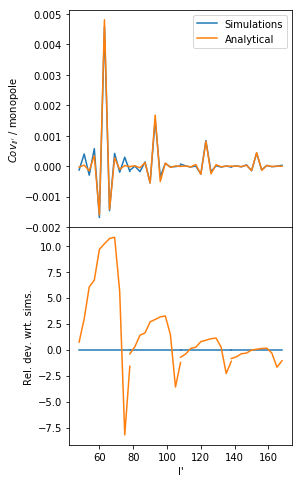

In [24]:
chi2_TTTE, corr_TTTE = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTTE[:lmax, :lmax], CovTh_TTTE[:lmax, :lmax], modes="TTTE", cl2sims=clTE[:, :lmax])

## TTEE

Checks for TTEE
Diagonal covariance matrix


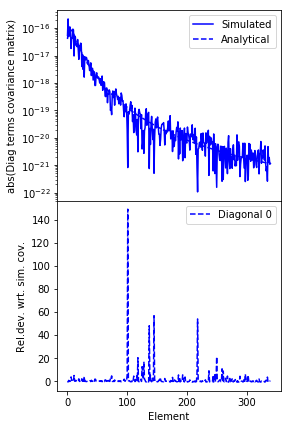

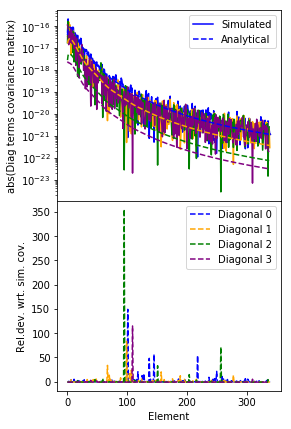

Chi2 distribution check


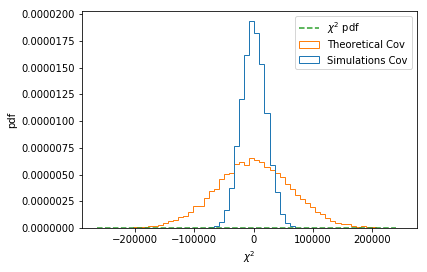

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.24914999999999998, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.5079502521861308, pvalue=0.0)
KS between th. and chi2 distributions:  KstestResult(statistic=0.5028831309433214, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006564449564426367, pvalue=0.3547909427370333)

Difference between analytic and sims. correlation matrix


/home/ardok/FPI/8.PCL_Covariance/notebooks/check_covariance_code/common.py:99: RuntimeWarning: invalid value encountered in sqrt
  return covariance / np.sqrt(c * c[:, None])


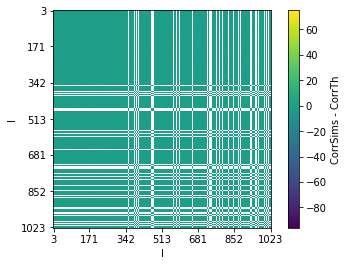

Eigenvalues vs l


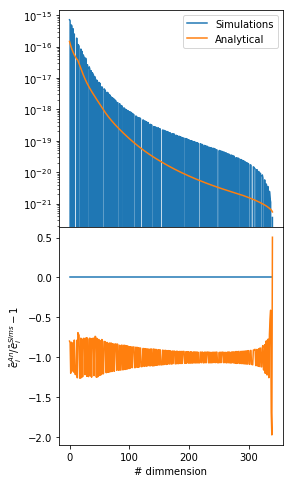

Row of cov. matrix.


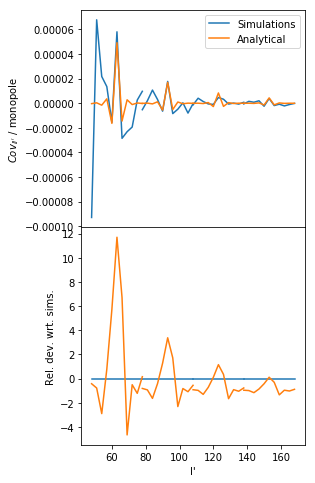

In [25]:
chi2_TTEE, corr_TTEE = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTEE[:lmax, :lmax], CovTh_TTEE[:lmax, :lmax], modes="TTEE", cl2sims=clEE[:, :lmax])

## TTBB

Checks for TTBB
Diagonal covariance matrix


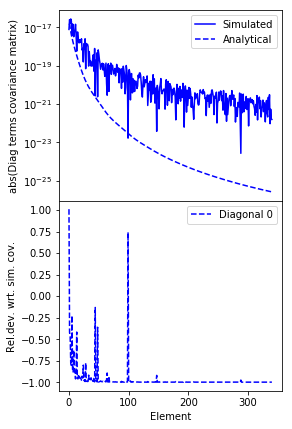

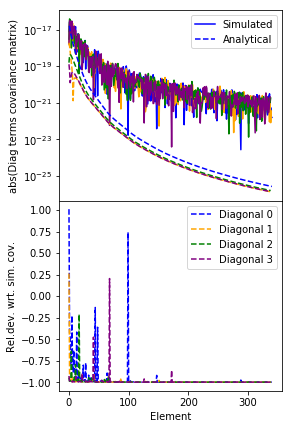

Chi2 distribution check


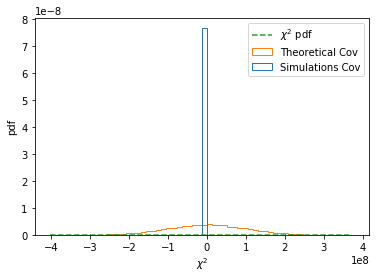

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.49955000000000005, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.5035999948536026, pvalue=0.0)
KS between th. and chi2 distributions:  KstestResult(statistic=0.50065, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005991990626859955, pvalue=0.46928458859190914)

Difference between analytic and sims. correlation matrix


/home/ardok/FPI/8.PCL_Covariance/notebooks/check_covariance_code/common.py:99: RuntimeWarning: invalid value encountered in sqrt
  return covariance / np.sqrt(c * c[:, None])


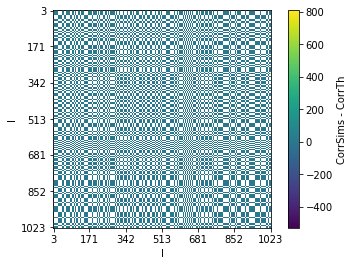

Eigenvalues vs l


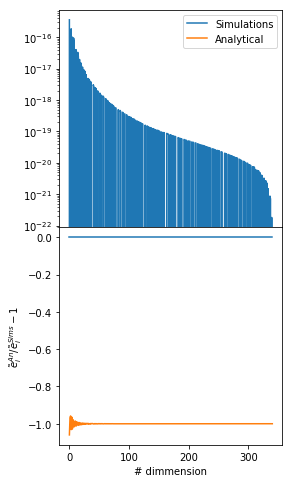

Row of cov. matrix.


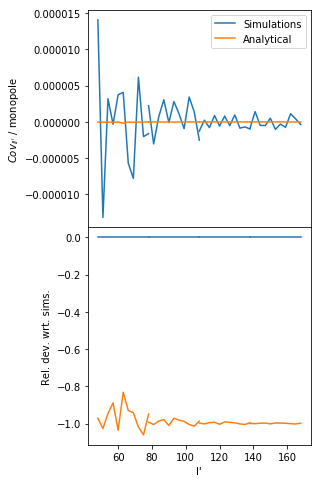

In [26]:
chi2_TTBB, corr_TTBB = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTBB[:lmax, :lmax], CovTh_TTBB[:lmax, :lmax], modes="TTBB", cl2sims=clBB[:, :lmax])

# Spin0 approximation

## TTTT

Checks for TTTT
Diagonal covariance matrix


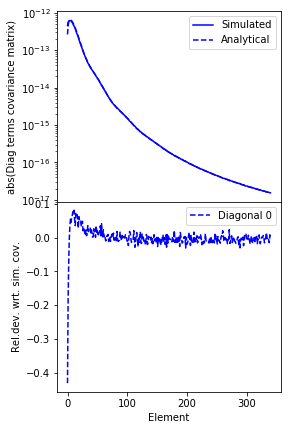

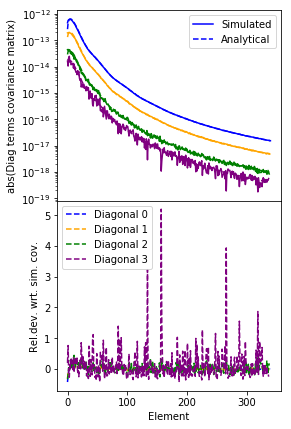

Chi2 distribution check


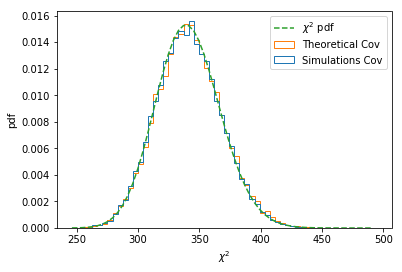

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.01100000000000001, pvalue=0.17668113134476654)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0071964520517123765, pvalue=0.2514750451452012)
KS between th. and chi2 distributions:  KstestResult(statistic=0.013833558769296928, pvalue=0.0009476296955860927)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006843085681410566, pvalue=0.306174828140944)

Difference between analytic and sims. correlation matrix


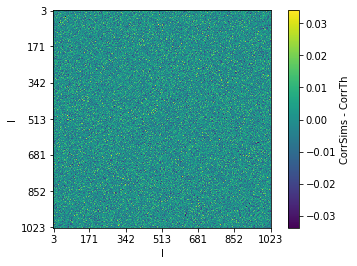

Eigenvalues vs l


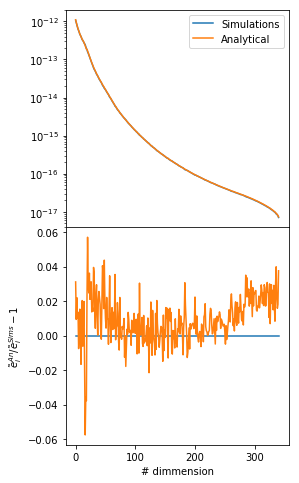

Row of cov. matrix.


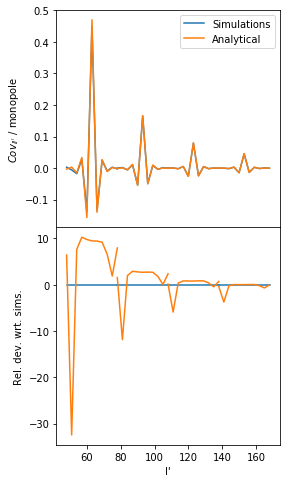

In [27]:
chi20_TTTT, corr0_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh0_TT[:lmax, :lmax], modes="TTTT")

## TETE

Checks for TETE
Diagonal covariance matrix


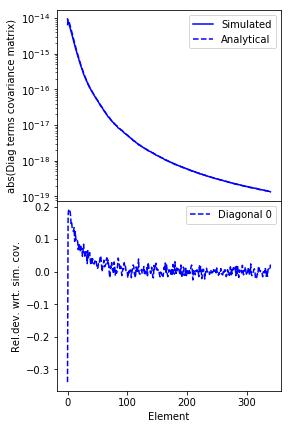

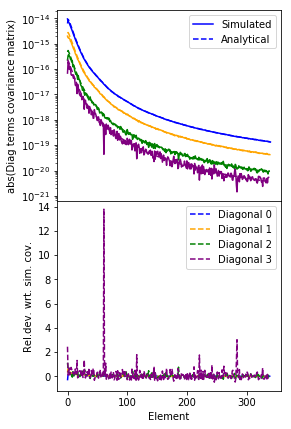

Chi2 distribution check


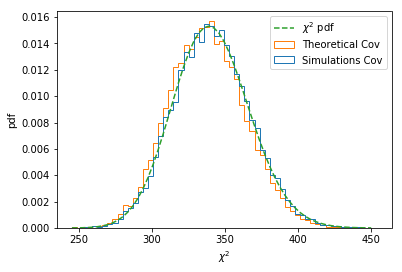

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.05169999999999997, pvalue=1.0674270545768505e-23)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.00371748567619834, pvalue=0.9450677806629686)
KS between th. and chi2 distributions:  KstestResult(statistic=0.04959622623958815, pvalue=3.71686247225192e-43)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0039656349329938445, pvalue=0.911534071640533)

Difference between analytic and sims. correlation matrix


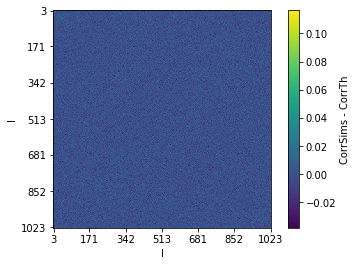

Eigenvalues vs l


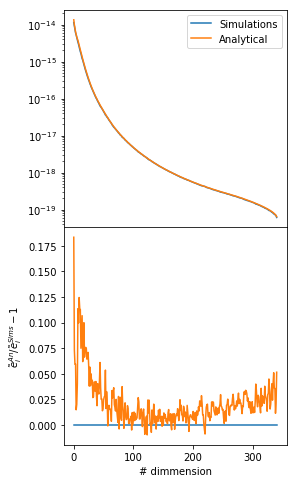

Row of cov. matrix.


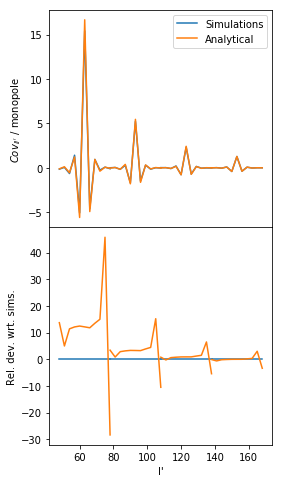

In [28]:
chi20_TETE, corr0_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh0_TE[:lmax, :lmax], modes="TETE")

## EEEE

Checks for EEEE
Diagonal covariance matrix


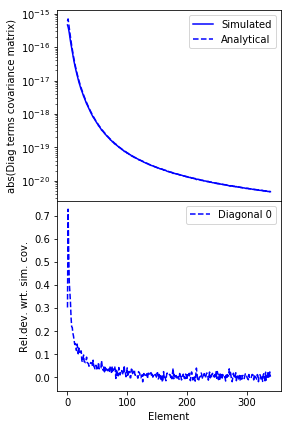

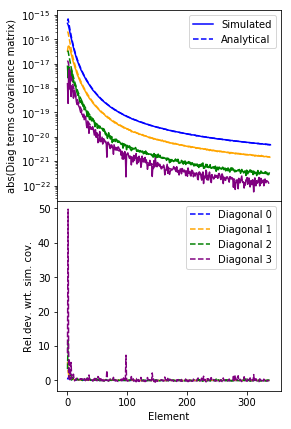

Chi2 distribution check


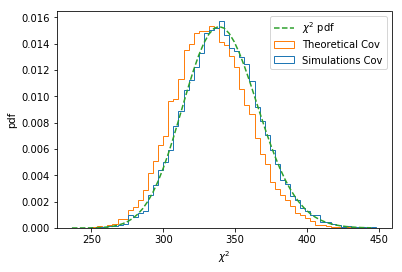

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.11434999999999995, pvalue=2.816842491252459e-114)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.003853499483614242, pvalue=0.9277813605188122)
KS between th. and chi2 distributions:  KstestResult(statistic=0.11306139964162443, pvalue=1.7364351865408186e-222)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008897180770984225, pvalue=0.08430443864443762)

Difference between analytic and sims. correlation matrix


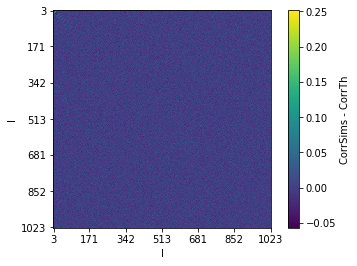

Eigenvalues vs l


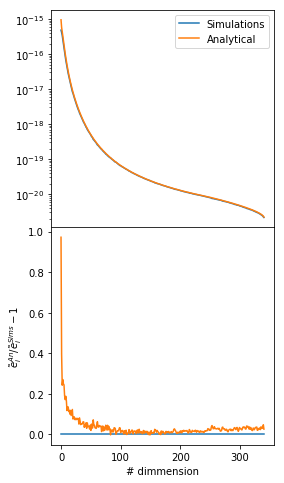

Row of cov. matrix.


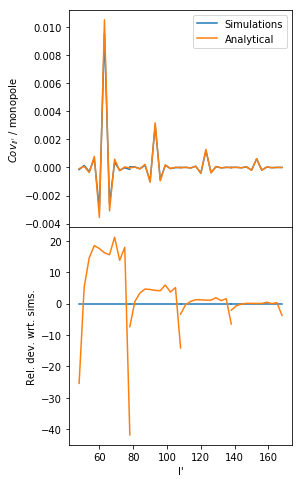

In [29]:
chi20_EEEE, corr0_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh0_EE[:lmax, :lmax], modes="EEEE")

## BBBB

Checks for BBBB
Diagonal covariance matrix


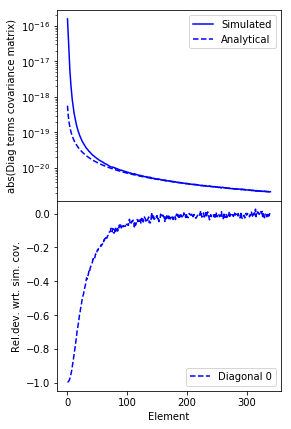

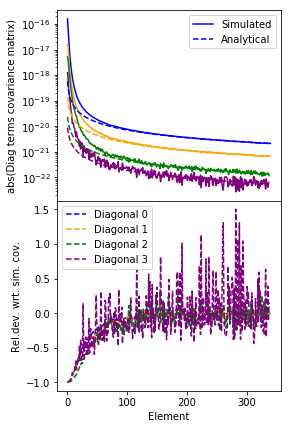

Chi2 distribution check


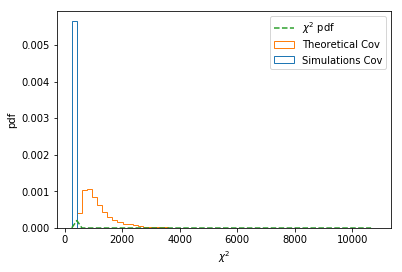

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.99805, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.008255590597542772, pvalue=0.1308996205190951)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9978787887252605, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005658986620955764, pvalue=0.5436518396933807)

Difference between analytic and sims. correlation matrix


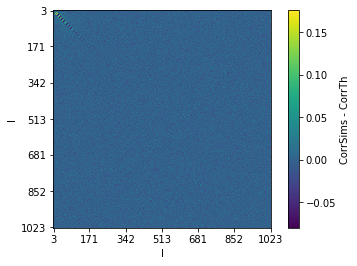

Eigenvalues vs l


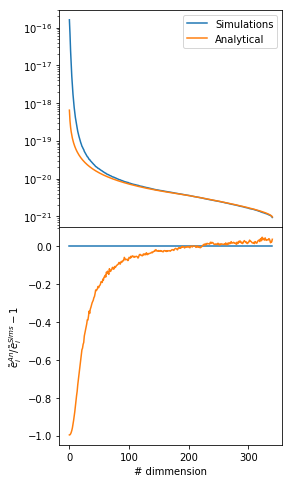

Row of cov. matrix.


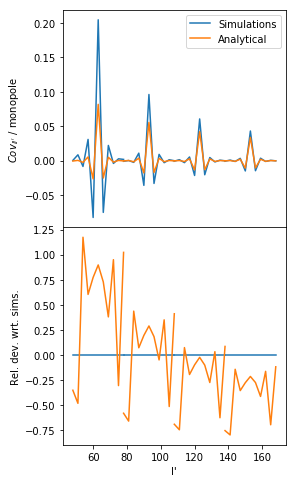

In [30]:
chi20_BBBB, corr0_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh0_BB[:lmax, :lmax], modes="BBBB")

## TBTB

Checks for TBTB
Diagonal covariance matrix


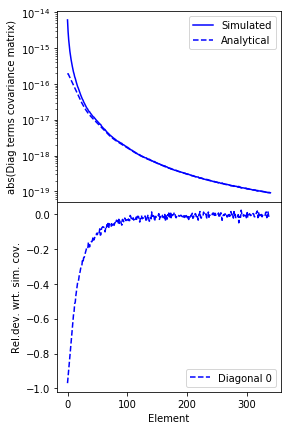

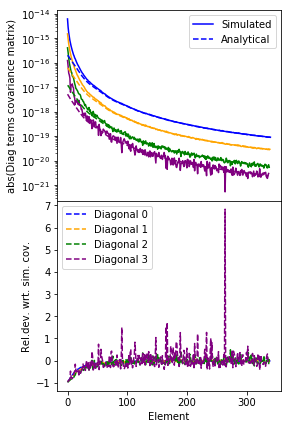

Chi2 distribution check


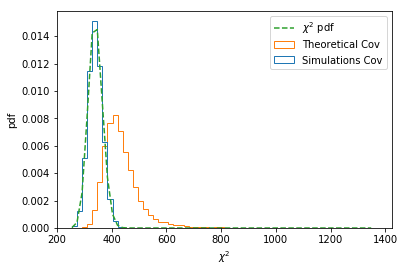

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.7638, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004426630850170449, pvalue=0.8280716263397345)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7627319384903902, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0034633338473690767, pvalue=0.9701024859409646)

Difference between analytic and sims. correlation matrix


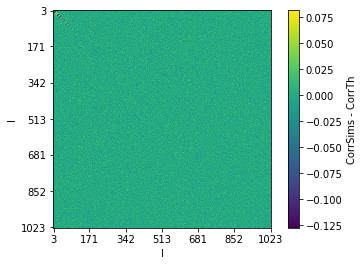

Eigenvalues vs l


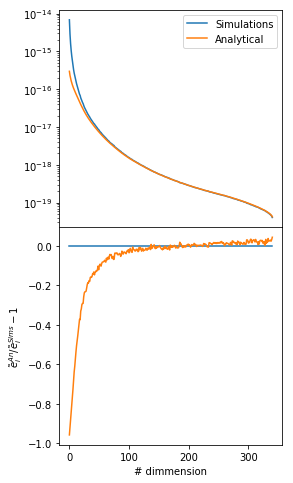

Row of cov. matrix.


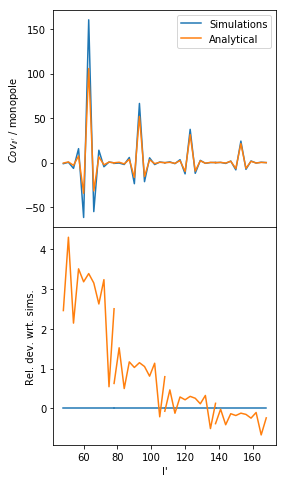

In [31]:
chi20_TBTB, corr0_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh0_TB[:lmax, :lmax], modes="TBTB")

## EBEB

Checks for EBEB
Diagonal covariance matrix


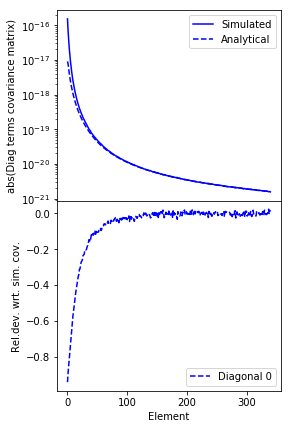

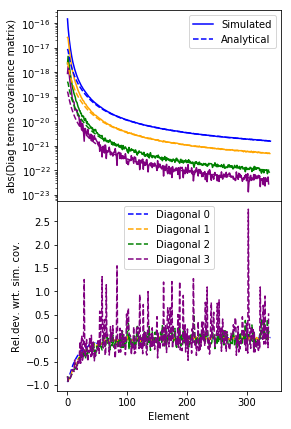

Chi2 distribution check


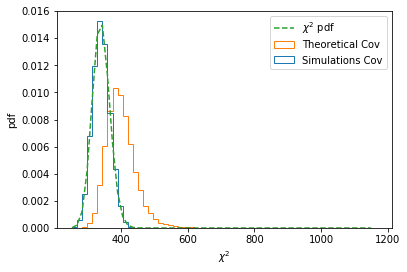

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.6241, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005585428445099849, pvalue=0.5606612915280346)
KS between th. and chi2 distributions:  KstestResult(statistic=0.6216026793029563, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007805817013296079, pvalue=0.17468832477749183)

Difference between analytic and sims. correlation matrix


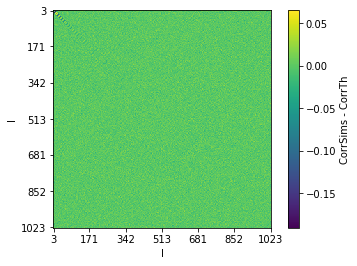

Eigenvalues vs l


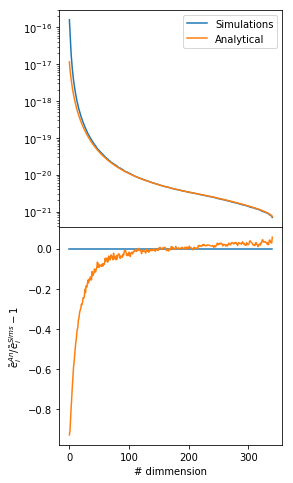

Row of cov. matrix.


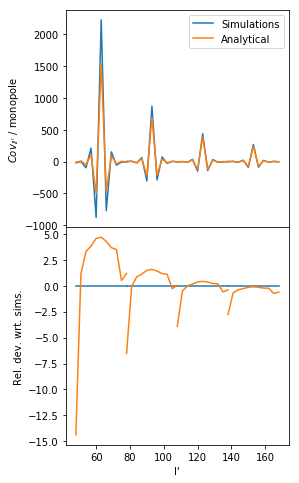

In [32]:
chi20_EBEB, corr0_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh0_EB[:lmax, :lmax], modes="EBEB")

# Naive approximation

## TTTT

Checks for TTTT
Diagonal covariance matrix


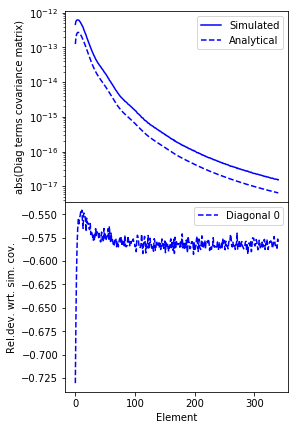

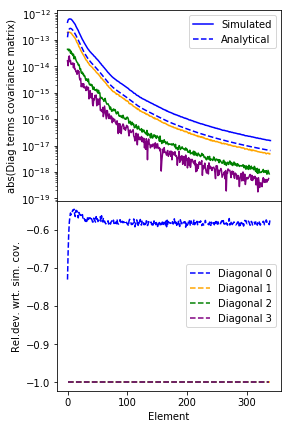

Chi2 distribution check


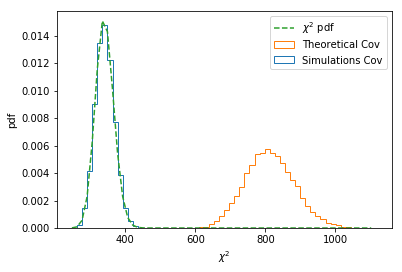

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0071964520517123765, pvalue=0.2514750451452012)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999582282, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0055016673997208, pvalue=0.5802263783382537)

Difference between analytic and sims. correlation matrix


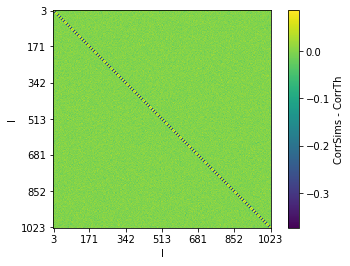

Eigenvalues vs l


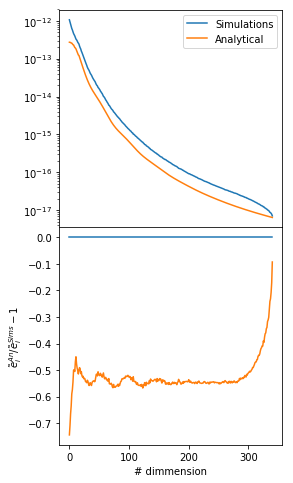

Row of cov. matrix.


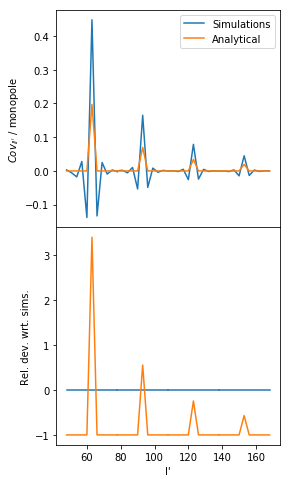

In [33]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax], modes="TTTT")

## TETE

Checks for TETE
Diagonal covariance matrix


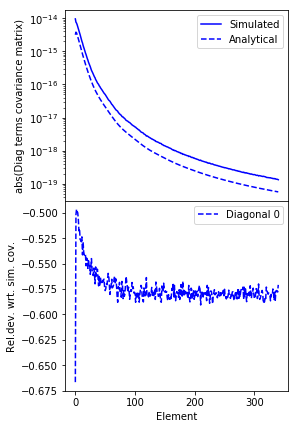

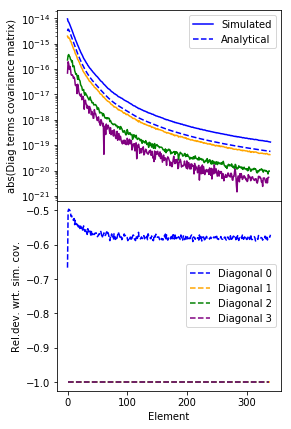

Chi2 distribution check


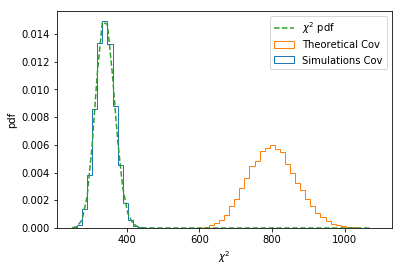

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.00371748567619834, pvalue=0.9450677806629686)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999992115, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005355828242043503, pvalue=0.6146761330333604)

Difference between analytic and sims. correlation matrix


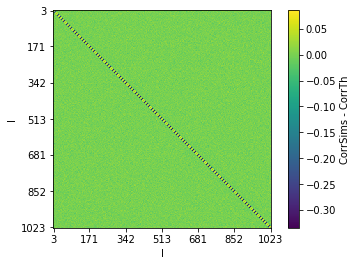

Eigenvalues vs l


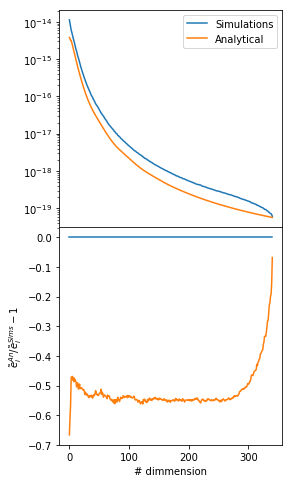

Row of cov. matrix.


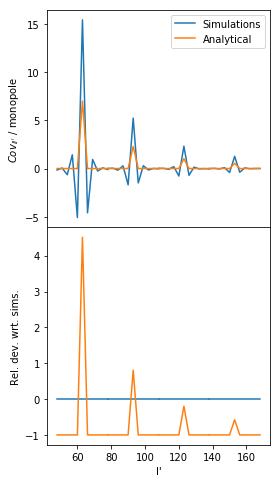

In [34]:
chi2N_TETE, corrN_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovThN_TE[:lmax, :lmax], modes="TETE")

## EEEE

Checks for EEEE
Diagonal covariance matrix


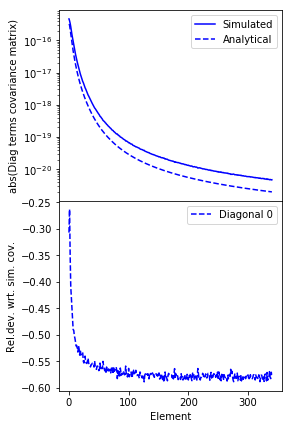

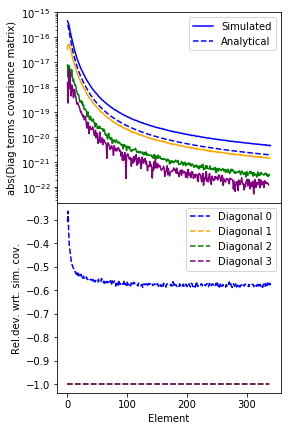

Chi2 distribution check


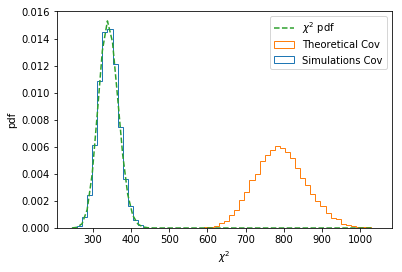

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.003853499483614242, pvalue=0.9277813605188122)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9999999999969055, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.008332068212351551, pvalue=0.1244279737654273)

Difference between analytic and sims. correlation matrix


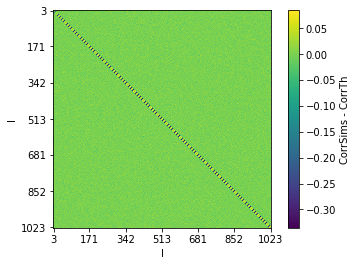

Eigenvalues vs l


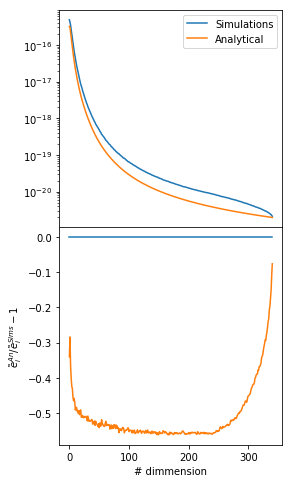

Row of cov. matrix.


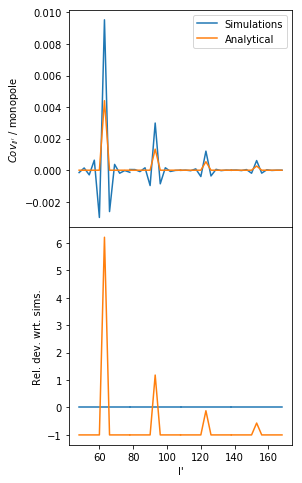

In [35]:
chi2N_EEEE, corrN_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovThN_EE[:lmax, :lmax], modes="EEEE")

## BBBB

Checks for BBBB
Diagonal covariance matrix


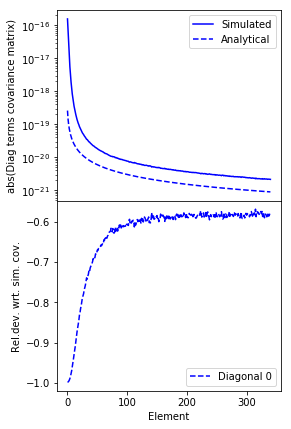

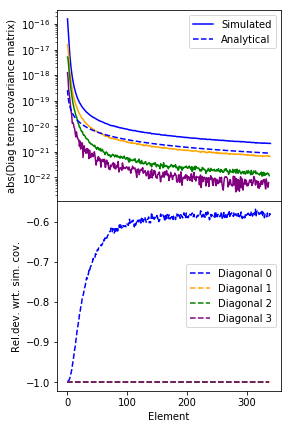

Chi2 distribution check


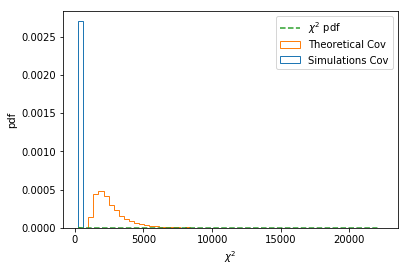

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.008255590597542772, pvalue=0.1308996205190951)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.004722041178716996, pvalue=0.7639530479163815)

Difference between analytic and sims. correlation matrix


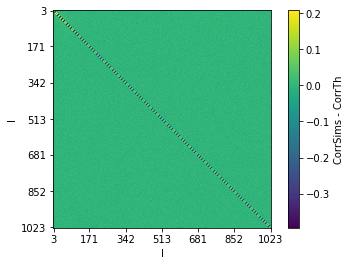

Eigenvalues vs l


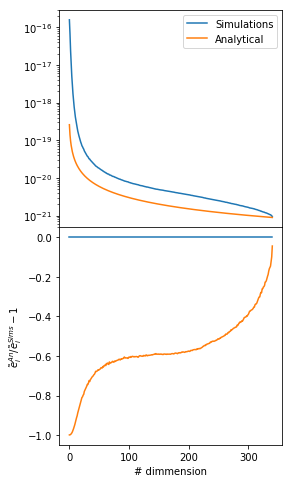

Row of cov. matrix.


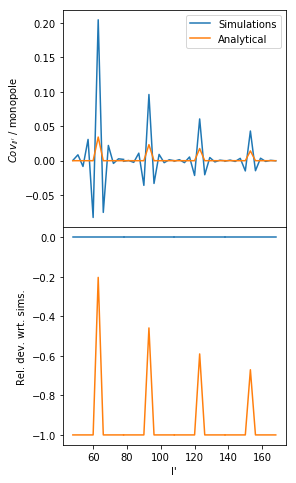

In [36]:
chi2N_BBBB, corrN_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovThN_BB[:lmax, :lmax], modes="BBBB")

## TBTB

Checks for TBTB
Diagonal covariance matrix


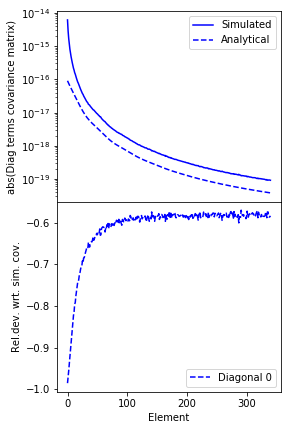

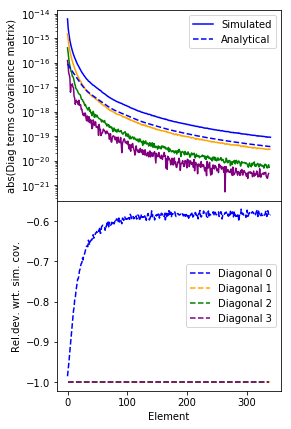

Chi2 distribution check


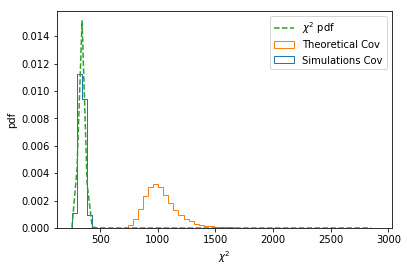

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004426630850170449, pvalue=0.8280716263397345)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00666413590983761, pvalue=0.3368425182355771)

Difference between analytic and sims. correlation matrix


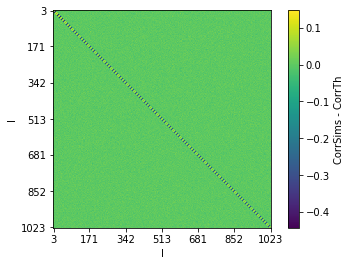

Eigenvalues vs l


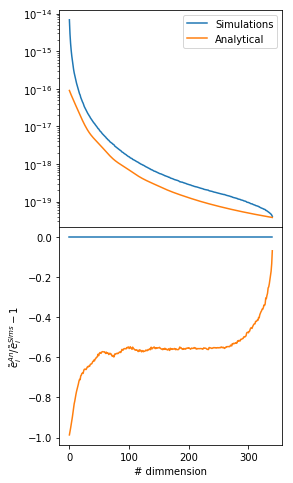

Row of cov. matrix.


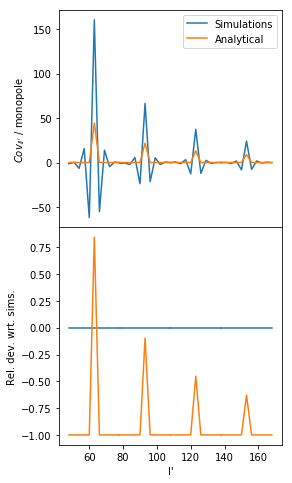

In [37]:
chi2N_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovThN_TB[:lmax, :lmax], modes="TBTB")

## EBEB

Checks for EBEB
Diagonal covariance matrix


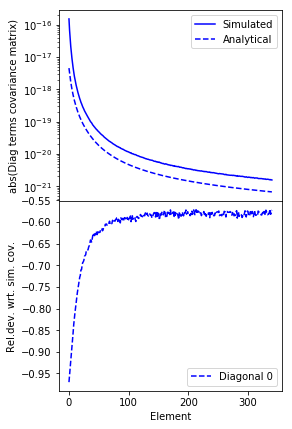

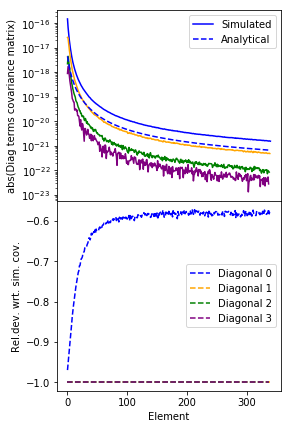

Chi2 distribution check


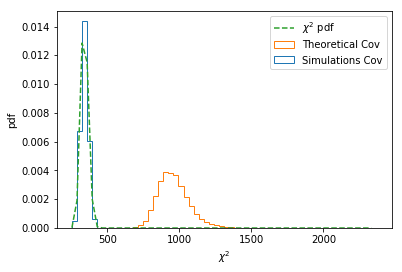

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005585428445099849, pvalue=0.5606612915280346)
KS between th. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0043411945332379465, pvalue=0.845307273363135)

Difference between analytic and sims. correlation matrix


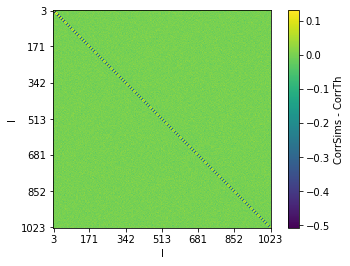

Eigenvalues vs l


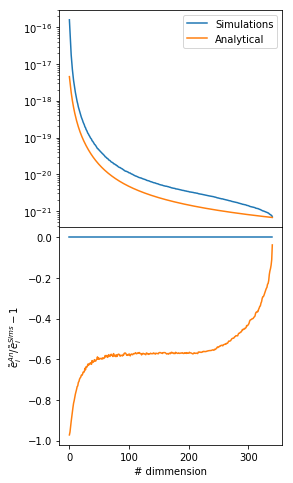

Row of cov. matrix.


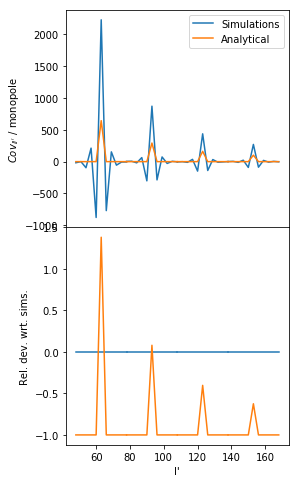

In [38]:
chi2N_EBEB, corrN_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovThN_EB[:lmax, :lmax], modes="EBEB")

# Comparing the approximations

## Diagonal & eigenvalues & row cov

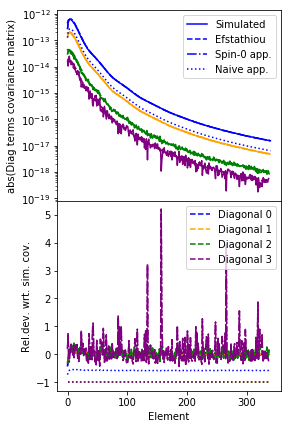

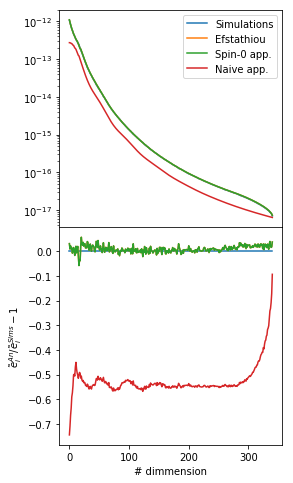

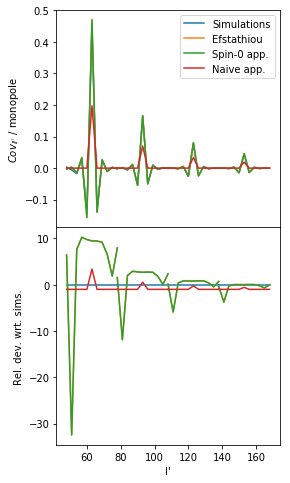

In [39]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TT[:lmax,:lmax], [CovTh_TT[:lmax,:lmax], CovTh0_TT[:lmax,:lmax], CovThN_TT[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTT,axis=0)[0]**2, principal=False)

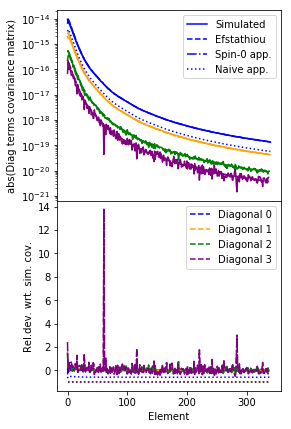

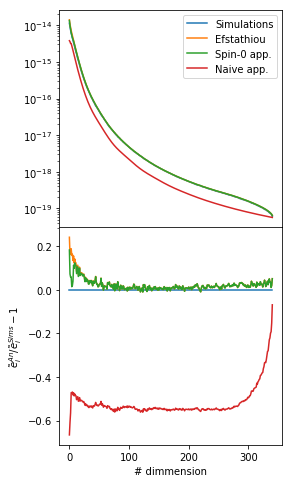

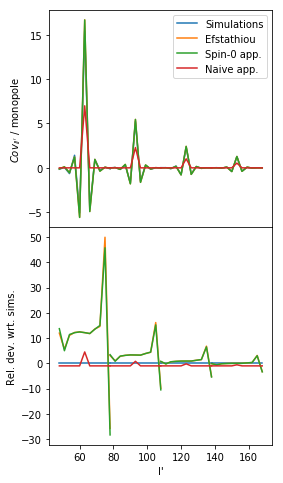

In [40]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TE[:lmax,:lmax], [CovTh_TE[:lmax,:lmax], CovTh0_TE[:lmax,:lmax], CovThN_TE[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTE,axis=0)[0]**2)

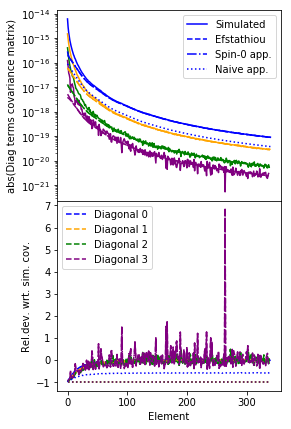

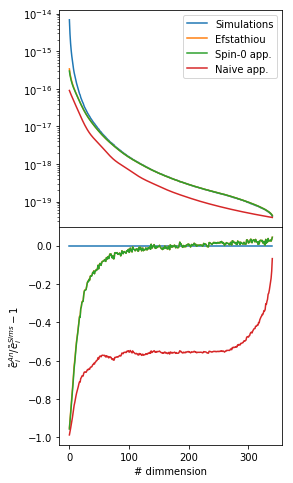

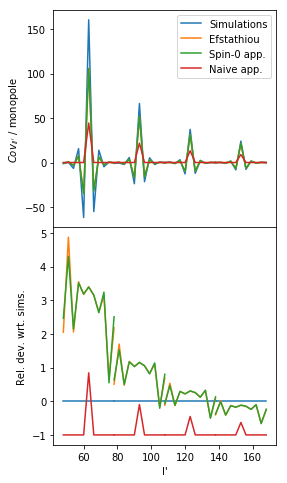

In [41]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TB[:lmax,:lmax], [CovTh_TB[:lmax,:lmax], CovTh0_TB[:lmax,:lmax], CovThN_TB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB, axis=0)[0]**2 )

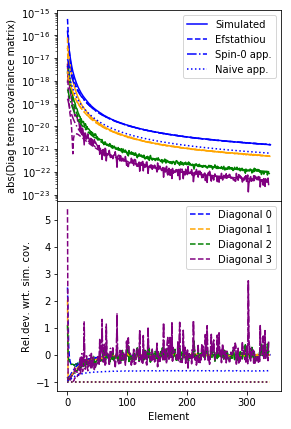

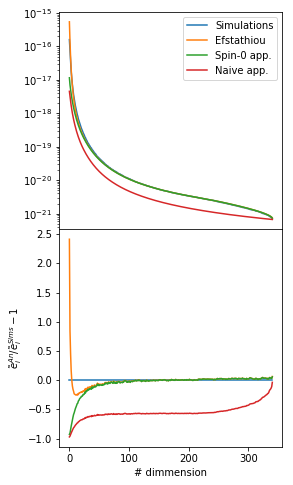

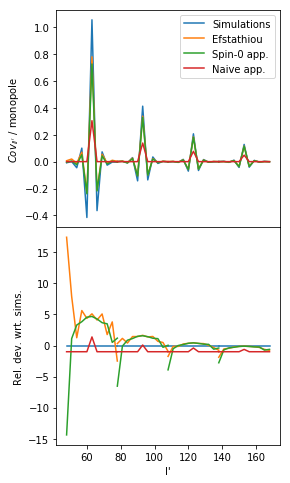

In [42]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EB[:lmax,:lmax], [CovTh_EB[:lmax,:lmax], CovTh0_EB[:lmax,:lmax], CovThN_EB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB,axis=0)[0]**2)

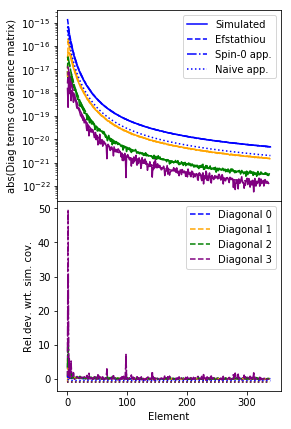

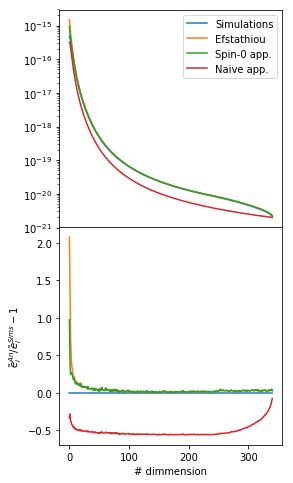

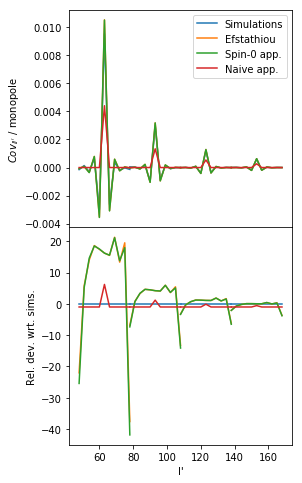

In [43]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EE[:lmax,:lmax], [CovTh_EE[:lmax,:lmax], CovTh0_EE[:lmax,:lmax], CovThN_EE[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clEE,axis=0)[0]**2)

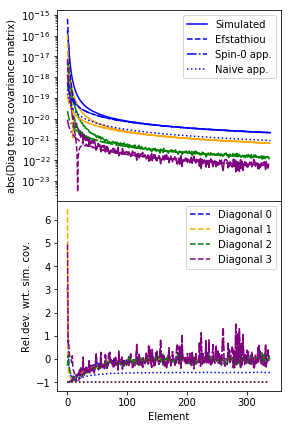

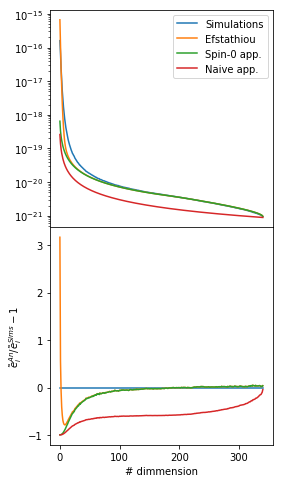

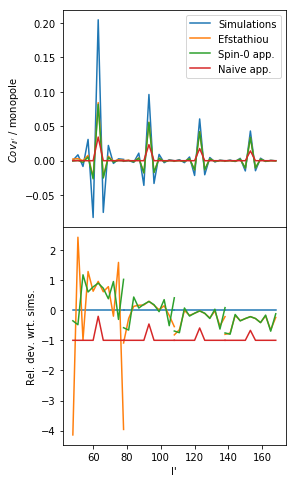

In [44]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_BB[:lmax,:lmax], [CovTh_BB[:lmax,:lmax], CovTh0_BB[:lmax,:lmax], CovThN_BB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clBB,axis=0)[0]**2, principal=False)

## $\chi^2$

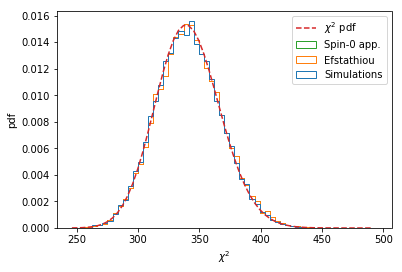

In [45]:
co.plot_chi2([chi2_TTTT[0], chi2_TTTT[1], chi20_TTTT[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

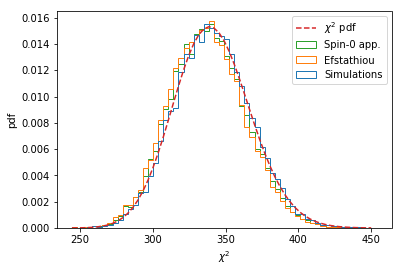

In [46]:
co.plot_chi2([chi2_TETE[0], chi2_TETE[1], chi20_TETE[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

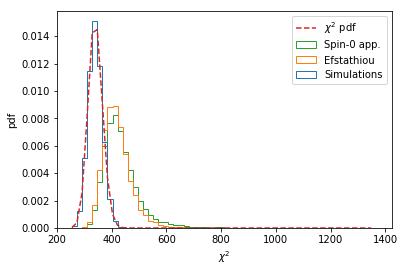

In [47]:
co.plot_chi2([chi2_TBTB[0], chi2_TBTB[1], chi20_TBTB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

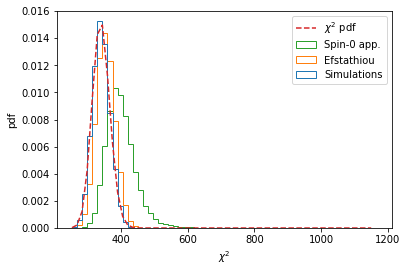

In [48]:
co.plot_chi2([chi2_EBEB[0], chi2_EBEB[1], chi20_EBEB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

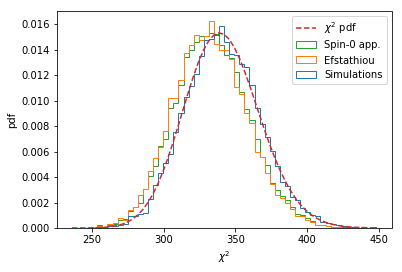

In [49]:
co.plot_chi2([chi2_EEEE[0], chi2_EEEE[1], chi20_EEEE[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

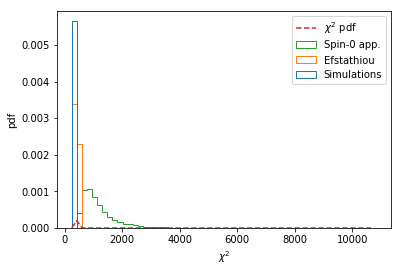

In [50]:
co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1], chi20_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

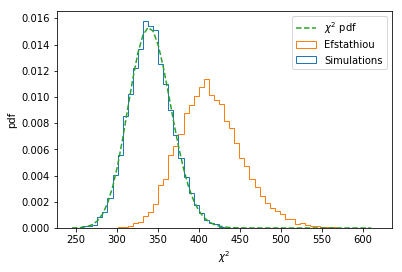

In [51]:
co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

## Covariance rows

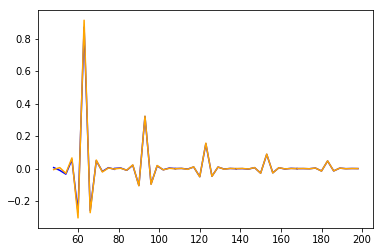

In [52]:
li = 20
for i in range(5):
    X = lbins[:lmax][li-5:li+6]
    #Y = CovSims_TT[li, li-5:li+5]/clTT[0, li-5:li+5]**2
    Y = CovSims_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2
    Yth = CovTh_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2

    li += 2*5

    plt.plot(X, Y, c='blue')
    plt.plot(X, Yth, c='orange')
    
plt.show()
plt.close()

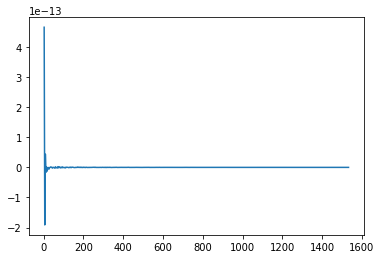

In [53]:
plt.plot(lbins, CovSims_TT[0])
plt.show()